In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seab
import math

In [2]:
#la matrice X dont le coefficient de la ième ligne et jème colonne contiendra le nombre de buts marqueés par i contre j avec i jouant à domicile
#la ième équipe est l'équipe ayant l'indice i dans la liste équipe qui est ordonné selon l'ordre alphabétique 
def remplir_matrice_X(data, equipes):
    nb_equipes = len(equipes)
    X = np.zeros((nb_equipes, nb_equipes))
    for index, row in data.iterrows(): #.iterrows renvoie des tuples contenant l'indice d'une ligne et la ligne elle meme qui est sous forme d'une sorte de dictionnaire
        equipe_domicile = row['HomeTeam'] # le nom de l'équipe jouant à domicile
        equipe_exterieure = row['AwayTeam'] #celui de celle jouant à l'extérieur
        buts_domicile = row['FTHG']
        #on récupère les indices des équipes dans la liste equipes
        i = equipes.index(equipe_domicile)
        j = equipes.index(equipe_exterieure)
        X[i][j] = buts_domicile
    return X
#la matrice Y dont le coefficient de la ième ligne et jèeme colonne contiendra le nombre de buts marqueés par j contre i avec j jouant à l'extérieur
def remplir_matrice_Y(data, equipes):
    nb_equipes = len(equipes)
    Y = np.zeros((nb_equipes, nb_equipes))
    for index, row in data.iterrows():
        equipe_domicile = row['HomeTeam']
        equipe_exterieure = row['AwayTeam']
        buts_domicile = row['FTAG']
        i = equipes.index(equipe_domicile)
        j = equipes.index(equipe_exterieure)
        Y[i][j] = buts_domicile
    return Y

In [3]:
#on calcule le nombre total de buts marqués par la ième équipe
def somme_buts_marqués(X, Y, i):
    tot_buts = 0
    for j in range(len(X)):
        if j != i:
            tot_buts += X[i][j] + Y[j][i]
    return tot_buts
#calcule le nombre de buts marqués en moyenne par une équipe et qui est à la fois le paramètre de la loi de Poisson
def calcul_lambda(X,Y,n):
    lamda=np.zeros((n,1))
    for i in range(n):
        tot_buts_i=somme_buts_marqués(X,Y,i)
        tot_matchs= (n-1)*2
        lamda[i][0]=tot_buts_i/tot_matchs
    return lamda

In [4]:
#simule un match on faisant un tirage aléatoire des buts selon la loi de Poisson
def simulate_match_1(lamda,i, j):
    team1_goals = np.random.poisson(lamda[i][0])
    team2_goals = np.random.poisson(lamda[j][0])

    if team1_goals > team2_goals:
        result = 'Team 1 wins'
    elif team1_goals < team2_goals:
        result = 'Team 2 wins'
    else:
        result = 'Draw'

    return team1_goals, team2_goals, result


In [5]:
#simulation du classement obtenu en moyenne à partir des données 
def classement_1(lamda, equipes, n):
    num_simulations = n
    total_points = {team: 0 for team in equipes}#dictionnaire qui va contenir le nombre total de points de chaque équipe sur toutes les simulations
    points_esp ={team: 0 for team in equipes}#dictionnaire qui va contenir le nombre de points gagnés en moyenne

    for _ in range(num_simulations):
        points = {team: 0 for team in equipes}

        for i in range(len(equipes)):
            for j in range(len(equipes)):
                if i != j:
                    team1_goals, team2_goals, result = simulate_match_1(lamda, i, j)
                    if team1_goals > team2_goals:
                        points[equipes[i]] += 3
                    elif team1_goals < team2_goals:
                        points[equipes[j]] += 3
                    else:
                        points[equipes[i]] += 1
                        points[equipes[j]] += 1

        for team in equipes:
            total_points[team] += points[team]
    for team in equipes:
        points_esp[team]=total_points[team]/num_simulations

    # conversion du dictionnaire des points en moyenne en DataFrame pour un tri facile
    df_classement = pd.DataFrame.from_dict(points_esp, orient='index', columns=['Points'])
    df_classement = df_classement.sort_values(by='Points', ascending=False)
    
    return df_classement

In [6]:
def simu_champ_1(data):
    equipes= sorted(set(data['HomeTeam']))
    X=remplir_matrice_X(data,equipes)
    Y=remplir_matrice_Y(data, equipes)
    lamdas= calcul_lambda(X,Y,len(equipes))
    print('classement espéré:')
    classement_esp=classement_1(lamdas,equipes, 10000)
    print(classement_esp)

In [7]:
#somme des buts encaissés par l'équipe i
def somme_buts_encaissés(X, Y, i):
    tot_buts = 0
    for j in range(len(X)):
        if j != i:
            tot_buts += X[j][i] + Y[i][j]
    return tot_buts

In [8]:
#somme des beta ou des alpha
def somme_coeffs(beta, i):
    tot_beta = 0
    for j in range(len(beta)):
        if j != i:
            tot_beta += beta[j]
    return 2 * tot_beta

In [9]:
#calcule des matrices colonnes contenant les capacités offensives et défensives de manière itérative
def calcul_coeffs(X, Y):
    nb_equipes = len(X)
    alpha = np.ones((nb_equipes, 1))
    beta = np.ones((nb_equipes, 1))
    for a in range(500):
        for i in range(nb_equipes):
            if i!=16:
                S2 = somme_coeffs(beta, i)
                S1 = somme_buts_marqués(X, Y, i)
                if S2 != 0:
                    alpha[i] = S1 / S2
        for i in range(nb_equipes):
            S4 = somme_buts_encaissés(X, Y, i)
            S3 = somme_coeffs(alpha, i)
            if S3 != 0:
                beta[i] = S4 / S3
    return alpha, beta

In [10]:
#calcule du lambda et du mu associés au match de i contre j à partir d'une matrice à 2 colonnes contenant les alpha et beta
def lamda(alpha_beta, i, j):
    alpha_i = alpha_beta[i][0]
    beta_j = alpha_beta[j][1]
    return alpha_i * beta_j

def mu(alpha_beta, i, j):
    beta_i = alpha_beta[i][1]
    alpha_j = alpha_beta[j][0]
    return alpha_j * beta_i

In [11]:
#on réunit tous les lambda et les mu dans respectivement une matrice L et une matrice M
def matrices(alpha_beta):
    L = np.zeros((20, 20))
    M = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            if j != i:
                L[i][j] = lamda(alpha_beta, i, j)
                M[i][j] = mu(alpha_beta, i, j)
    return L, M

In [12]:
#on simule le championnat grace à cette 1ère amélioration
def simulate_match_2(L, M, i, j):
    team1_goals = np.random.poisson(L[i][j])
    team2_goals = np.random.poisson(M[i][j])
    if team1_goals > team2_goals:
        result = 'Team 1 wins'
    elif team1_goals < team2_goals:
        result = 'Team 2 wins'
    else:
        result = 'Draw'
    return team1_goals, team2_goals, result

def classement_2(L, M, equipes, n):
    num_simulations = n
    total_points = {team: 0 for team in equipes}
    points_esp={teams: 0 for teams in equipes}
    for _ in range(num_simulations):
        points = {team: 0 for team in equipes}
        for i in range(len(equipes)):
            for j in range(len(equipes)):
                if i != j:
                    team1_goals, team2_goals, result = simulate_match_2(L, M, i, j)
                    if team1_goals > team2_goals:
                        points[equipes[i]] += 3
                    elif team1_goals < team2_goals:
                        points[equipes[j]] += 3
                    else:
                        points[equipes[i]] += 1
                        points[equipes[j]] += 1
        for team in equipes:
            total_points[team] += points[team]
    for team in equipes:
        points_esp[team]=total_points[team]/num_simulations

    #conversion du dictionnaire des points en moyenne en DataFrame pour un tri facile
    df_classement = pd.DataFrame.from_dict(points_esp, orient='index', columns=['Points'])
    df_classement = df_classement.sort_values(by='Points', ascending=False)
    
    return df_classement

In [13]:
#simulation complète 2
def simu_champ_2(data):
    equipes = sorted(set(data['HomeTeam']))
    X = remplir_matrice_X(data, equipes)
    Y = remplir_matrice_Y(data, equipes)
    alpha, beta = calcul_coeffs(X, Y)
    alpha_beta = np.concatenate((alpha, beta), axis=1)
    L, M = matrices(alpha_beta)
    classement_final=classement_2(L, M, equipes, 10000)
    print('le classement espéré est')
    print(classement_final)

In [14]:
#le gamma qui représente l'avantage de jouer à domicile
def gamma(data):
    matchs = sorted(list(zip(data['HomeTeam'], data['AwayTeam'], data['FTHG'], data['FTAG'])))
# Initialiser un dictionnaire pour stocker les buts marqués à domicile et à l'extérieur par chaque équipe
    buts_par_equipe = {}
    facteurs=[]

    for equipe_domicile, equipe_exterieur, buts_domicile, buts_exterieur in matchs:
    # Ajouter les buts marqués à domicile à l'équipe à domicile
        if equipe_domicile not in buts_par_equipe:
            buts_par_equipe[equipe_domicile] = {"domicile": 0, "exterieur": 0}
        buts_par_equipe[equipe_domicile]["domicile"] += buts_domicile
# Ajouter les buts marqués à l'extérieur à l'équipe à l'extérieur
        if equipe_exterieur not in buts_par_equipe:
            buts_par_equipe[equipe_exterieur] = {"domicile": 0, "exterieur": 0}
        buts_par_equipe[equipe_exterieur]["exterieur"] += buts_exterieur
    for equipe, buts in buts_par_equipe.items():
        facteurs.append(buts['domicile']/buts['exterieur'])
    somme=0
    for i in range(20):
        somme+=facteurs[i]
    gamma=somme/20
    return gamma

In [15]:
def gamma_dom(X,Y):
    gamm=np.zeros((len(X),1))
    for i in range(len(X)):
        tot_buts_ext=0
        tot_buts_dom=0
        for j in range(len(X)):
            tot_buts_dom+=X[i][j]
            tot_buts_ext+=Y[j][i]
        gamm[i]=tot_buts_dom/tot_buts_ext
    return gamm

In [16]:
def gamma_ext(X,Y):
    gamm=np.zeros((len(X),1))
    for i in range(len(X)):
        tot_buts_ext=0
        tot_buts_dom=0
        for j in range(len(X)):
            tot_buts_dom+=X[i][j]
            tot_buts_ext+=Y[j][i]
        gamm[i]=tot_buts_ext/tot_buts_dom
    return gamm

In [17]:
#simulation avec cette 2ème amélioration
def simulate_match_3(L, M, i, j, gamma):
    team1_goals = np.random.poisson(L[i][j] * gamma)
    team2_goals = np.random.poisson(M[i][j])
    if team1_goals > team2_goals:
        result = 'Team 1 wins'
    elif team1_goals < team2_goals:
        result = 'Team 2 wins'
    else:
        result = 'Draw'
    return team1_goals, team2_goals, result

def classement_3(L, M, data, equipes, n, gamma):
    num_simulations = n
    total_points = {team: 0 for team in equipes}
    points_esp = {team: 0 for team in equipes}
    for _ in range(n):
        points = {team: 0 for team in equipes}
        for index, row in data.iterrows():
            equipe_dom= row['HomeTeam']
            equipe_ext=row['AwayTeam']
            i= equipes.index(equipe_dom)
            j= equipes.index(equipe_ext)
            equipe_dom_buts, equipe_ext_buts, result = simulate_match_3(L, M, i, j, gamma)
            if equipe_dom_buts > equipe_ext_buts:
                points[equipes[i]] += 3
            elif equipe_dom_buts < equipe_ext_buts:
                points[equipes[j]] += 3
            else:
                points[equipes[i]] += 1
                points[equipes[j]] += 1
        for team in equipes:
            total_points[team] += points[team]
    for team in equipes:
        points_esp[team]=total_points[team]/num_simulations

    # Convertir le dictionnaire des points totaux en DataFrame pour un tri facile
    df_classement = pd.DataFrame.from_dict(points_esp, orient='index', columns=['Points'])
    df_classement = df_classement.sort_values(by='Points', ascending=False)
    
    return df_classement

In [18]:
#simulation complète 3
def simu_champ_3(data):
    equipes = sorted(set(data['HomeTeam']))
    X = remplir_matrice_X(data, equipes)
    Y = remplir_matrice_Y(data, equipes)
    alpha, beta = calcul_coeffs(X, Y)
    alpha_beta = np.concatenate((alpha, beta), axis=1)
    gamma_val = gamma(data)
    L, M = matrices(alpha_beta)
    classement_final=classement_3(L, M, data, equipes, 10000, gamma_val)
    print('le classement espéré est')
    print(classement_final)

In [19]:
#simulation de la 2ème moitié de championnat en se basant sur la 1ère
def simu_champ_4(data):
    moitié=len(data)//2
    first_half = data.iloc[:moitié]
    second_half = data.iloc[moitié:]
    equipes = sorted(set(data['HomeTeam']))
    X = remplir_matrice_X(first_half, equipes)
    Y = remplir_matrice_Y(first_half, equipes)
    alpha, beta = calcul_coeffs(X, Y)
    alpha_beta = np.concatenate((alpha, beta), axis=1)
    gamma_val = gamma(data)
    print(gamma_val)
    L, M = matrices(alpha_beta)
    return classement_3(L, M,second_half, equipes, 10000, gamma_val)

In [20]:
#loi de poisson
def poisson(lamda,k):
    return (math.exp(-lamda)*((lamda)**k))/math.factorial(k)

In [21]:
#matrice cintenant les différentes probabilités de résultat d'un match donné
def proba(lamda,mu,n):
    probas=np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            probas[i][j]=poisson(lamda,i)*poisson(mu,j)
    return probas

In [22]:
#calcul des capacités offensives et défensives après une certaine journée de championnat
def coeffs(data, journée, equipes):
    matchs_joués=0
    matchs_joués+=10*journée
    matchs_vus=data.iloc[:matchs_joués]
    X= remplir_matrice_X(matchs_vus, equipes)
    Y= remplir_matrice_Y(matchs_vus, equipes)
    return calcul_coeffs(X,Y)

In [23]:
data_1=pd.read_csv('/home/safsaf/Téléchargements/E0 2024.csv')
simu_champ_1(data_1)

classement espéré:
                   Points
Man City          73.3585
Arsenal           70.7699
Liverpool         68.0846
Newcastle         67.4404
Chelsea           62.8028
Aston Villa       62.1412
Tottenham         60.9414
West Ham          51.8580
Crystal Palace    49.8578
Man United        49.8228
Brentford         49.0638
Fulham            48.3783
Brighton          48.2481
Bournemouth       47.7254
Luton             46.3902
Wolves            44.7419
Nott'm Forest     44.2004
Burnley           38.2752
Everton           37.3952
Sheffield United  33.5947


In [24]:
simu_champ_2(data_1)

le classement espéré est
                   Points
Arsenal           88.4407
Man City          87.1096
Liverpool         78.6887
Newcastle         65.8225
Aston Villa       61.7481
Chelsea           61.0744
Tottenham         60.7819
Man United        52.2964
Crystal Palace    52.2884
Fulham            49.1466
Brighton          48.7136
Brentford         47.7102
West Ham          45.5787
Bournemouth       45.4085
Everton           44.7525
Wolves            43.7282
Nott'm Forest     42.1896
Luton             35.7490
Burnley           31.8186
Sheffield United  19.0462


In [25]:
simu_champ_3(data_1)

le classement espéré est
                   Points
Arsenal           89.7607
Man City          88.4418
Liverpool         79.7209
Newcastle         66.4455
Aston Villa       62.3920
Chelsea           61.6215
Tottenham         61.0258
Man United        52.5653
Crystal Palace    52.5428
Fulham            49.5567
Brighton          48.8365
Brentford         47.9640
West Ham          45.6880
Bournemouth       45.5677
Everton           44.7880
Wolves            43.9595
Nott'm Forest     42.1275
Luton             35.4834
Burnley           31.3537
Sheffield United  18.5329


entrez l_équpie qui joue à domicile Man City
entrez l_équipe qui joue à l_extérieur Arsenal
entrez un fichier csv contenant les données du championnat /home/safsaf/Téléchargements/E0 2024.csv
quelle journée voulez vous simuler 25


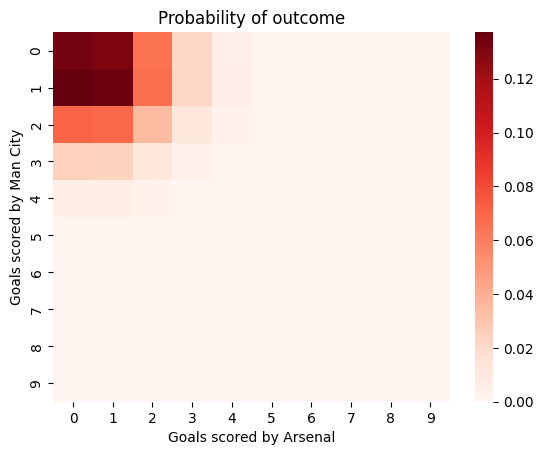

In [26]:
#résultats probables d'un match à partie des matchs précèdents
def simu(data, equipe_dom, equipe_ext, n):
    equipes=sorted(set(data['HomeTeam']))
    journée=n-1
    alpha, beta= coeffs(data,journée, equipes)
    alpha_beta = np.concatenate((alpha, beta), axis=1)
    gamm= gamma(data)
    L, M=matrices(alpha_beta)
    i=equipes.index(equipe_dom)
    j=equipes.index(equipe_ext)
    lmda=L[i][j]*gamm
    mu=M[i][j]
    probas=proba(lmda,mu,10)
    seab.heatmap(probas, fmt='.2f', cmap="Reds", cbar=True)

#configuration des labels
    plt.xlabel(f'Goals scored by {equipe_ext}')
    plt.ylabel(f'Goals scored by {equipe_dom}')
    plt.title('Probability of outcome')
#affichage de la heatmap
    plt.show()

equipe_dom=input('entrez l_équpie qui joue à domicile')
equipe_ext=input('entrez l_équipe qui joue à l_extérieur')
data=pd.read_csv(input('entrez un fichier csv contenant les données du championnat'))
journee=int(input('quelle journée voulez vous simuler'))
simu(data, equipe_dom, equipe_ext, journee)

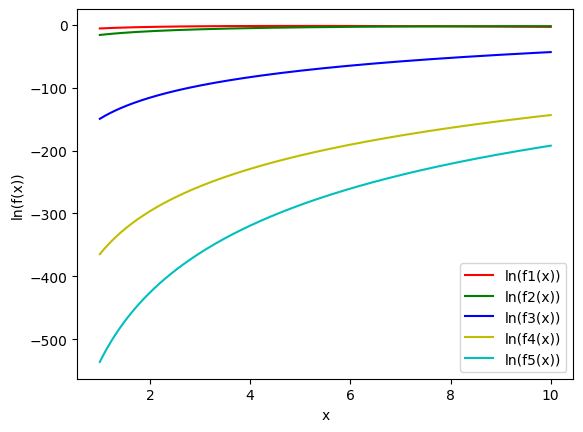

In [27]:


def f1(x):
    exp=math.exp(-x)
    fact=math.factorial(5)
    return ((x**5)*exp)/fact

def f2(x):
    exp=math.exp(-x)
    fact=math.factorial(10)
    return ((x**10)*exp)/fact

def f3(x):
    exp=math.exp(-x)
    fact=math.factorial(50)
    return ((x**50)*exp)/fact

def f4(x):
    exp=math.exp(-x)
    fact=math.factorial(100)
    return ((x**100)*exp)/fact

# Définir la plage de valeurs pour x
x = np.linspace(1, 10, 1000)
# Calculer les valeurs de ln(x)
y1 = np.zeros((1000,1))
y2= np.zeros((1000,1))
y3= np.zeros((1000,1))
y4 = np.zeros((1000,1))
y5=np.zeros((1000,1))
for i in range(1000):
    y1[i]=np.log(f1(x[i]))
    y2[i]=np.log(f2(x[i]))
    y3[i]=np.log(f3(x[i]))
    y4[i]=np.log(f4(x[i]))
    y5[i]=np.log(f1(x[i])*f2(x[i])*f3(x[i])*f4(x[i]))

plt.plot(x, y1, 'r', label='ln(f1(x))')
plt.plot(x, y2, 'g', label='ln(f2(x))')
plt.plot(x, y3,'b', label='ln(f3(x))')
plt.plot(x, y4, 'y',label='ln(f4(x))')
plt.plot(x,y5, 'c', label='ln(f5(x))')

# Ajouter des titres et des légendes
plt.xlabel('x')
plt.ylabel('ln(f(x))')
plt.legend()

# Afficher le graphique
plt.show()


In [28]:
data=pd.read_csv('/home/safsaf/Téléchargements/E0 2024.csv')
equipes=sorted(set(data['HomeTeam']))
equipe= pd.DataFrame(equipes)
print(equipe)

                   0
0            Arsenal
1        Aston Villa
2        Bournemouth
3          Brentford
4           Brighton
5            Burnley
6            Chelsea
7     Crystal Palace
8            Everton
9             Fulham
10         Liverpool
11             Luton
12          Man City
13        Man United
14         Newcastle
15     Nott'm Forest
16  Sheffield United
17         Tottenham
18          West Ham
19            Wolves


In [29]:
X= remplir_matrice_X(data, equipes)
Y= remplir_matrice_Y(data, equipes)
def calcul_coeffs(X, Y):
    nb_equipes = len(X)
    alpha = np.ones((nb_equipes, 1))
    beta = np.ones((nb_equipes, 1))
    x=np.zeros(501)
    y=np.zeros(501)
    y[0]=1
    for a in range(500):
        for i in range(nb_equipes):
            if i!=16:
                S2 = somme_coeffs(beta, i)
                S1 = somme_buts_marqués(X, Y, i)
                if S2 != 0:
                    alpha[i] = S1 / S2
            y[a+1] = alpha[0][0]
            x[a+1]=a
        for i in range(nb_equipes):
            S4 = somme_buts_encaissés(X, Y, i)
            S3 = somme_coeffs(alpha, i)
            if S3 != 0:
                beta[i] = S4 / S3
    return alpha, beta, x, y

alpha, beta, x, y= calcul_coeffs(X,Y)
alpha_beta= np.concatenate((alpha,beta), axis=1)
colonnes = ['alphas','betas']
# Noms des lignes
index = [equipes[i] for i in range(20)]
alpha_beta= np.concatenate((alpha, beta), axis=1)

# Transformation de la matrice en DataFrame avec noms de colonnes et d'index
df = pd.DataFrame(alpha_beta, columns=colonnes, index=index)

# Affichage du DataFrame
colonnes = ['alphas','betas']
# Noms des lignes
index = [equipes[i] for i in range(20)]
alpha_beta= np.concatenate((alpha, beta), axis=1)

# Transformation de la matrice en DataFrame avec noms de colonnes et d'index
df = pd.DataFrame(alpha_beta, columns=colonnes, index=index)
df = df.sort_values(by='alphas', ascending=False)
print(df)


                    alphas     betas
Man City          2.591135  0.535715
Arsenal           2.445504  0.454846
Newcastle         2.349245  0.969503
Liverpool         2.334471  0.640827
Chelsea           2.129188  0.978406
Aston Villa       2.097825  0.946424
Tottenham         2.042436  0.944800
West Ham          1.673433  1.133198
Crystal Palace    1.568080  0.885325
Man United        1.568080  0.885325
Brentford         1.549632  0.991616
Brighton          1.518039  0.944939
Fulham            1.516760  0.929661
Bournemouth       1.496679  1.020479
Luton             1.463380  1.293326
Wolves            1.383217  0.986607
Nott'm Forest     1.357774  1.016179
Burnley           1.146215  1.175471
Everton           1.093311  0.767354
Sheffield United  1.000000  1.560418


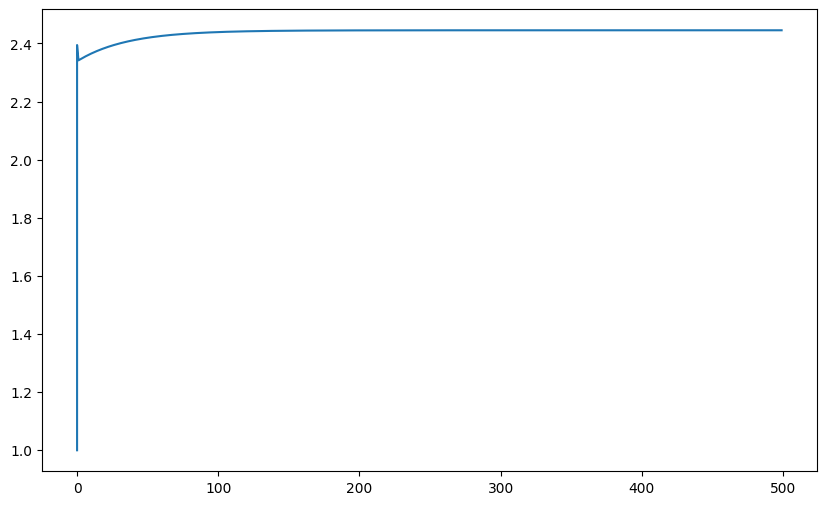

In [30]:

plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.show()

In [31]:
def calcul_coeffs(X, Y):
    nb_equipes = len(X)
    alpha = np.ones((nb_equipes, 1))
    beta = np.ones((nb_equipes, 1))
    for a in range(500):
        for i in range(nb_equipes):
            if i!=16:
                S2 = somme_coeffs(beta, i)
                S1 = somme_buts_marqués(X, Y, i)
                if S2 != 0:
                    alpha[i] = S1 / S2
        for i in range(nb_equipes):
            S4 = somme_buts_encaissés(X, Y, i)
            S3 = somme_coeffs(alpha, i)
            if S3 != 0:
                beta[i] = S4 / S3
    return alpha, beta

data1= pd.read_csv('/home/safsaf/Téléchargements/F1.csv')
equipes1=sorted(set(data1['HomeTeam']))
X1= remplir_matrice_X(data1, equipes1)
Y1= remplir_matrice_Y(data1, equipes1)
alpha1, beta1 =calcul_coeffs(X1,Y1)
print(alpha1)

[[0.71696364]
 [1.39112271]
 [1.04537176]
 [0.99672032]
 [0.93494894]
 [0.95505271]
 [0.6811624 ]
 [1.58259208]
 [1.25160554]
 [0.61703129]
 [0.865276  ]
 [0.93155217]
 [0.74072495]
 [0.79730749]
 [1.01222919]
 [0.73075765]
 [1.        ]
 [0.74144989]
 [0.77290875]
 [0.89987592]]


In [32]:
print(equipes1)

['Auxerre', 'Bordeaux', 'Caen', 'Le Mans', 'Lens', 'Lille', 'Lorient', 'Lyon', 'Marseille', 'Metz', 'Monaco', 'Nancy', 'Nice', 'Paris SG', 'Rennes', 'Sochaux', 'St Etienne', 'Strasbourg', 'Toulouse', 'Valenciennes']


In [33]:
simu_champ_2(data1)

le classement espéré est
               Points
Lyon          75.9073
Bordeaux      70.1998
Nancy         62.0722
Lille         61.3663
St Etienne    61.2699
Marseille     60.9901
Nice          54.7967
Rennes        54.0812
Valenciennes  53.2314
Le Mans       49.8495
Caen          48.8995
Lorient       48.3901
Toulouse      46.9935
Lens          46.0856
Monaco        46.0731
Paris SG      45.7017
Sochaux       44.5583
Auxerre       38.3093
Strasbourg    37.3492
Metz          28.2741


In [34]:
def calcul_coeffs(X, Y):
    nb_equipes = len(X)
    alpha = np.ones((nb_equipes, 1))
    beta = np.ones((nb_equipes, 1))
    for a in range(500):
        for i in range(nb_equipes):
            if i!=16:
                S2 = somme_coeffs(beta, i)
                S1 = somme_buts_marqués(X, Y, i)
                if S2 != 0:
                    alpha[i] = S1 / S2
        for i in range(nb_equipes):
            S4 = somme_buts_encaissés(X, Y, i)
            S3 = somme_coeffs(alpha, i)
            if S3 != 0:
                beta[i] = S4 / S3
    return alpha, beta

In [35]:
def coeffs(matchs_vus, equipes):
    X= remplir_matrice_X(matchs_vus, equipes)
    Y= remplir_matrice_Y(matchs_vus, equipes)
    return calcul_coeffs(X,Y)

entrez l_équpie qui joue à domicile Man City
entrez l_équipe qui joue à l_extérieur Arsenal
entrez un fichier csv contenant les données du championnat /home/safsaf/Téléchargements/E0 2024.csv
quelle journée voulez vous simuler 25


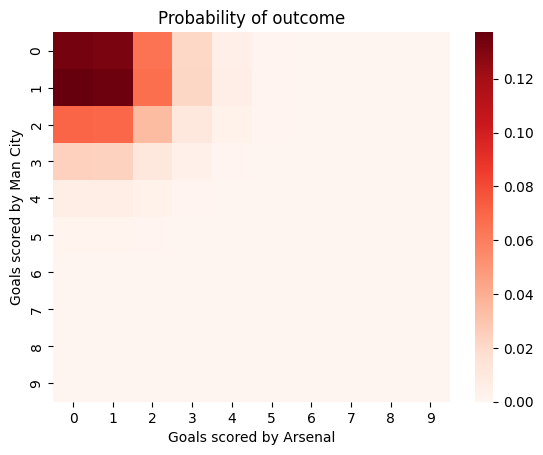

In [38]:
def simu(data, equipe_dom, equipe_ext, n):
    equipes=sorted(set(data['HomeTeam']))
    journée=n-1
    matchs_joués=10*journée
    matchs_vus = data.iloc[:matchs_joués]
    alpha, beta= coeffs(matchs_vus, equipes)
    alpha_beta= np.concatenate((alpha, beta), axis=1)
    gamm= gamma(matchs_vus)
    L, M=matrices(alpha_beta)
    i=equipes.index(equipe_dom)
    j=equipes.index(equipe_ext)
    lmda=L[i][j]*gamm
    mu=M[i][j]
    probas=proba(lmda,mu,10)
    seab.heatmap(probas, annot=False, fmt='.2f', cmap="Reds", cbar=True)

#configuration des labels
    plt.xlabel(f'Goals scored by {equipe_ext}')
    plt.ylabel(f'Goals scored by {equipe_dom}')
    plt.title('Probability of outcome')
#affichage de la heatmap
    plt.show()

equipe_dom=input('entrez l_équpie qui joue à domicile')
equipe_ext=input('entrez l_équipe qui joue à l_extérieur')
data=pd.read_csv(input('entrez un fichier csv contenant les données du championnat'))
journee=int(input('quelle journée voulez vous simuler'))
simu(data, equipe_dom, equipe_ext, journee)